In [1]:
import pandas as pd
import csv
import langid
import numpy as np
import requests
import json
import re
import string
import nltk
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk.stem import SnowballStemmer
from nltk.probability import FreqDist
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# download the Indonesian stopwords from NLTK
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\irfan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load data
data = pd.read_csv('negative.csv', encoding='utf-8')
print (data)

                                                   text     label
0     Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...  negative
1     Belum jadi kok sudah mau memindahkan ASN Pak? ...  negative
2     Sampai di IKN, asn nya mengeluh...oala disini ...  negative
3     Emang ikn jadi kapan? Kayak dia masih menjabat...  negative
4     Tdk semudah itu ASN wajib pindah ke IKN tahun ...  negative
...                                                 ...       ...
8729  Program IKN pertama: Membangun kerjasama denga...  negative
8730  Dirangkul demi menyejahterakan anak-cucu para ...  negative
8731  Rapim TNI-POLRI seharusnya banyak hal lain yan...  negative
8732  Harusnya para gub itu bukan bawa tanah tp bawa...  negative
8733  Siapa bilang kemping di IKN tak ada hasilnya, ...  negative

[8734 rows x 2 columns]


In [4]:
# Cek apakah 'case_folding' ada dalam dataframe
if 'text' in data.columns:
    # Ambil kolom 'case_folding' dari dataframe
    kolom_case_folding = data['text']
    
    # Fungsi untuk memisahkan hashtag
    def pisahkan_hashtag(kalimat):
        # Menggunakan regex untuk mencocokkan pola hashtag
        pola = r'#[A-Za-z0-9_]+'
        hasil = re.findall(pola, kalimat)
        
        # Mengganti hashtag dengan kata terpisah
        for hashtag in hasil:
            kata_terpisah = re.sub(r'([a-z])([A-Z])', r'\1 \2', hashtag)
            kalimat = kalimat.replace(hashtag, kata_terpisah)
        
        return kalimat

    # Memisahkan hashtag pada setiap kalimat dalam kolom 'case_folding'
    data['pisah_hashtag&kata'] = kolom_case_folding.apply(pisahkan_hashtag)
    
    # Cetak dataframe untuk memverifikasi hasilnya
    print(data)
else:
    print("Kolom 'case_folding' tidak ada dalam dataframe.")

                                                   text     label  \
0     Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...  negative   
1     Belum jadi kok sudah mau memindahkan ASN Pak? ...  negative   
2     Sampai di IKN, asn nya mengeluh...oala disini ...  negative   
3     Emang ikn jadi kapan? Kayak dia masih menjabat...  negative   
4     Tdk semudah itu ASN wajib pindah ke IKN tahun ...  negative   
...                                                 ...       ...   
8729  Program IKN pertama: Membangun kerjasama denga...  negative   
8730  Dirangkul demi menyejahterakan anak-cucu para ...  negative   
8731  Rapim TNI-POLRI seharusnya banyak hal lain yan...  negative   
8732  Harusnya para gub itu bukan bawa tanah tp bawa...  negative   
8733  Siapa bilang kemping di IKN tak ada hasilnya, ...  negative   

                                     pisah_hashtag&kata  
0     Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...  
1     Belum jadi kok sudah mau memindahkan ASN Pak? ...

In [5]:
# Menyimpan hasil identifikasi ke dalam file CSV
data.to_csv("hasil2stem/handling_hashtag.csv", index=False)

In [6]:
data['pisah_hashtag&kata']

0       Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...
1       Belum jadi kok sudah mau memindahkan ASN Pak? ...
2       Sampai di IKN, asn nya mengeluh...oala disini ...
3       Emang ikn jadi kapan? Kayak dia masih menjabat...
4       Tdk semudah itu ASN wajib pindah ke IKN tahun ...
                              ...                        
8729    Program IKN pertama: Membangun kerjasama denga...
8730    Dirangkul demi menyejahterakan anak-cucu para ...
8731    Rapim TNI-POLRI seharusnya banyak hal lain yan...
8732    Harusnya para gub itu bukan bawa tanah tp bawa...
8733    Siapa bilang kemping di IKN tak ada hasilnya, ...
Name: pisah_hashtag&kata, Length: 8734, dtype: object

In [7]:
# Import corpus dari nltk
from nltk.tokenize import word_tokenize

# Fungsi untuk menghapus tanda baca menggunakan regex
def hapus_tanda_baca(kata):
    return re.sub(r'[^\w\s-]', '', kata)

# Fungsi untuk melakukan preprocessing pada kolom teks
def preprocess_text(text):

    # Menghapus karakter non-ASCII
    text = remove_non_ascii(text)

    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+|\#', '', text)

    # Tokenisasi kalimat menjadi kata-kata
    kata_kata = word_tokenize(text)

    # Menghapus tanda baca dari setiap kata
    kata_kata_tanpa_tanda_baca = [hapus_tanda_baca(kata) for kata in kata_kata]

    # Menggabungkan kata-kata kembali menjadi kalimat
    kalimat_tanpa_tanda_baca = ' '.join(kata_kata_tanpa_tanda_baca)

    # Menggantikan tanda baca dengan spasi tunggal menggunakan regex
    kalimat_final = re.sub(r'(?<=[^\w\s-])', ' ', kalimat_tanpa_tanda_baca)

    # Menggantikan multiple spasi dengan satu spasi menggunakan regex
    kalimat_tanpa_spasi_ganda = re.sub(r'\s+', ' ', kalimat_final)

    # Remove special characters and digits
    kalimat_tanpa_tanda_baca_dan_digit = re.sub(r'[^\w\s-]', '', kalimat_tanpa_spasi_ganda)
    kalimat_tanpa_digit = re.sub(r'\d+', '', kalimat_tanpa_tanda_baca_dan_digit)

    # Convert to lowercase
    kalimat_final = kalimat_tanpa_digit.lower()

    # Remove whitespace leading & trailing
    kalimat_final = kalimat_final.strip()

    # Remove single char
    kalimat_final = re.sub(r"\b[a-zA-Z]\b", "", kalimat_final)

    return kalimat_final

def remove_non_ascii(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

# Melakukan preprocessing pada kolom teks
data['text_cleaning'] = data['pisah_hashtag&kata'].apply(preprocess_text)

In [8]:
import ast

filename = "Final_1.txt"

with open(filename, "r", encoding='utf-8') as file:
    contents = file.read()
    slangs_dict = ast.literal_eval(contents)

print(slangs_dict)

{'tdk': 'tidak', 'jg': 'juga', 'ikn': 'ibu kota negara', 'jd': 'jadi', 'krn': 'karena', 'Bs': 'Bisa', 'Mgkn': 'Mungkin', 'byk': 'banyak', 'thdp': 'terhadap', 'yg': 'yang', 'gpp': 'tidak apa-apa', 'trmsk': 'termasuk', 'bs': 'bisa', 'sm': 'sama', 'msh': 'masih', 'mkn': 'makin', 'g': 'tidak', 'brplah': 'berapalah', 'sdh': 'sudah', 'trus': 'terus', 'ASN': 'Aparatur Sipil Negara', 'gw': 'saya', 'mukin': 'mungkin', 'pling': 'paling', 'gub': 'gubernur', 'blm': 'belum', 'dg': 'dengan', '@': 'di', 'abis': 'habis', 'ad': 'ada', 'adlh': 'adalah', 'afaik': 'as far as i know', 'ahaha': 'haha', 'aj': 'saja', 'ajep-ajep': 'dunia gemerlap', 'ak': 'saya', 'akika': 'aku', 'akkoh': 'aku', 'akuwh': 'aku', 'alay': 'norak', 'alow': 'halo', 'ambilin': 'ambilkan', 'ancur': 'hancur', 'anjrit': 'anjing', 'anter': 'antar', 'ap2': 'apa-apa', 'apasih': 'apa sih', 'apes': 'sial', 'aps': 'apa', 'aq': 'saya', 'aquwh': 'aku', 'asbun': 'asal bunyi', 'aseekk': 'asyik', 'asekk': 'asyik', 'asem': 'asam', 'aspal': 'asli te

In [9]:
slangs = {r"\b{}\b".format(k): v for k, v in slangs_dict.items()}

data['text_normalisasi'] = data['text_cleaning'].replace(slangs, regex=True)

In [10]:
data['text_normalisasi']

0       lho dia yang minta ibu kota negara kok otorita...
1       belum jadi kok sudah mau memindahkan asn pak y...
2       sampai di ibu kota negara asn nya mengeluh oal...
3       emang ibu kota negara jadi kapan kayak dia mas...
4       tidak semudah itu asn wajib pindah ke ibu kota...
                              ...                        
8729    program ibu kota negara pertama membangun kerj...
8730    dirangkul demi menyejahterakan anak-cucu para ...
8731    rapim tentara nasional indonesia-polri seharus...
8732    harusnya para gubernur itu bukan bawa tanah ta...
8733    siapa bilang kemping di ibu kota negara tidak ...
Name: text_normalisasi, Length: 8734, dtype: object

In [11]:
# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

data['tweet_tokens'] = data['text_normalisasi'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n') 
print(data['tweet_tokens'].head())
print('\n\n\n')

Tokenizing Result : 

0    [lho, dia, yang, minta, ibu, kota, negara, kok...
1    [belum, jadi, kok, sudah, mau, memindahkan, as...
2    [sampai, di, ibu, kota, negara, asn, nya, meng...
3    [emang, ibu, kota, negara, jadi, kapan, kayak,...
4    [tidak, semudah, itu, asn, wajib, pindah, ke, ...
Name: tweet_tokens, dtype: object






In [12]:
# Menyimpan hasil identifikasi ke dalam file CSV
data.to_csv("hasil2stem/Tweet_all_negative.csv", index=False)

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# ----------------------- get stopword from NLTK stopword -------------------------------
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah', '-',])

# ----------------------- add stopword from txt file ------------------------------------
# read txt stopword using pandas
txt_stopword = pd.read_csv("daftar_filter_stopword_120722.txt", names= ["stopwords"], header = None)

# convert stopword string to list & append additional stopword
list_stopwords.extend(txt_stopword["stopwords"][0])

# ---------------------------------------------------------------------------------------

# convert list to dictionary
list_stopwords = set(list_stopwords)


#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

data['tweet_tokens_WSW'] = data['tweet_tokens'].apply(stopwords_removal) 


print(data['tweet_tokens_WSW'])

0       [lho, kota, negara, otoritas, beban, iya, moda...
1               [memindahkan, asn, kota, negara, menteri]
2       [kota, negara, asn, mengeluh, oalah, seminggu,...
3       [emang, kota, negara, kayak, menjabat, boro-boro]
4       [semudah, asn, wajib, pindah, kota, negara, in...
                              ...                        
8729    [program, kota, negara, membangun, kerja, kota...
8730    [dirangkul, menyejahterakan, anak-cucu, oligar...
8731    [rapim, tentara, nasional, indonesia-polri, di...
8732    [gubernur, bawa, tanah, bawa, kas, dikumpulkan...
8733    [kemping, kota, negara, hasilnya, pencabutan, ...
Name: tweet_tokens_WSW, Length: 8734, dtype: object


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\irfan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
data

,text,label,pisah_hashtag&kata,text_cleaning,text_normalisasi,tweet_tokens,tweet_tokens_WSW
0,"Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...",negative,"Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...",lho dia yg minta ikn kok otorita di bebani ya ...,lho dia yang minta ibu kota negara kok otorita...,"[lho, dia, yang, minta, ibu, kota, negara, kok...","[lho, kota, negara, otoritas, beban, iya, moda..."
1,Belum jadi kok sudah mau memindahkan ASN Pak? ...,negative,Belum jadi kok sudah mau memindahkan ASN Pak? ...,belum jadi kok sudah mau memindahkan asn pak y...,belum jadi kok sudah mau memindahkan asn pak y...,"[belum, jadi, kok, sudah, mau, memindahkan, as...","[memindahkan, asn, kota, negara, menteri]"
2,"Sampai di IKN, asn nya mengeluh...oala disini ...",negative,"Sampai di IKN, asn nya mengeluh...oala disini ...",sampai di ikn asn nya mengeluh oala disini bar...,sampai di ibu kota negara asn nya mengeluh oal...,"[sampai, di, ibu, kota, negara, asn, nya, meng...","[kota, negara, asn, mengeluh, oalah, seminggu,..."
3,Emang ikn jadi kapan? Kayak dia masih menjabat...,negative,Emang ikn jadi kapan? Kayak dia masih menjabat...,emang ikn jadi kapan kayak dia masih menjabat ...,emang ibu kota negara jadi kapan kayak dia mas...,"[emang, ibu, kota, negara, jadi, kapan, kayak,...","[emang, kota, negara, kayak, menjabat, boro-boro]"
4,Tdk semudah itu ASN wajib pindah ke IKN tahun ...,negative,Tdk semudah itu ASN wajib pindah ke IKN tahun ...,tdk semudah itu asn wajib pindah ke ikn tahun ...,tidak semudah itu asn wajib pindah ke ibu kota...,"[tidak, semudah, itu, asn, wajib, pindah, ke, ...","[semudah, asn, wajib, pindah, kota, negara, in..."
...,...,...,...,...,...,...,...
8729,Program IKN pertama: Membangun kerjasama denga...,negative,Program IKN pertama: Membangun kerjasama denga...,program ikn pertama membangun kerjasama dengan...,program ibu kota negara pertama membangun kerj...,"[program, ibu, kota, negara, pertama, membangu...","[program, kota, negara, membangun, kerja, kota..."
8730,Dirangkul demi menyejahterakan anak-cucu para ...,negative,Dirangkul demi menyejahterakan anak-cucu para ...,dirangkul demi menyejahterakan anak-cucu para ...,dirangkul demi menyejahterakan anak-cucu para ...,"[dirangkul, demi, menyejahterakan, anak-cucu, ...","[dirangkul, menyejahterakan, anak-cucu, oligar..."
8731,Rapim TNI-POLRI seharusnya banyak hal lain yan...,negative,Rapim TNI-POLRI seharusnya banyak hal lain yan...,rapim tni-polri seharusnya banyak hal lain yan...,rapim tentara nasional indonesia-polri seharus...,"[rapim, tentara, nasional, indonesia-polri, se...","[rapim, tentara, nasional, indonesia-polri, di..."
8732,Harusnya para gub itu bukan bawa tanah tp bawa...,negative,Harusnya para gub itu bukan bawa tanah tp bawa...,harusnya para gub itu bukan bawa tanah tp bawa...,harusnya para gubernur itu bukan bawa tanah ta...,"[harusnya, para, gubernur, itu, bukan, bawa, t...","[gubernur, bawa, tanah, bawa, kas, dikumpulkan..."


In [15]:
data.to_csv("hasil2stem/hasil_preprocessing_negative.csv")

In [16]:
import csv
import pandas as pd

# Memuat data leksikon positif dan negatif
lexicon_positive = dict()
with open('lexicon_positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # melewati baris header
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open('lexicon_negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # melewati baris header
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Daftar kata-kata positif dan negatif
positive_words = list(lexicon_positive.keys())
negative_words = list(lexicon_negative.keys())

# Fungsi untuk menentukan polaritas sentimen dari tweet        
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    positive_found = []
    negative_found = []
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
            positive_found.append((word, lexicon_positive[word]))
        if word in lexicon_negative:
            score += lexicon_negative[word]
            negative_found.append((word, lexicon_negative[word]))
    polarity = ''
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity, positive_found, negative_found

# Asumsi `data` adalah DataFrame yang Anda miliki
# Contoh: data = pd.read_csv('your_input_file.csv')

# Hasil dari menentukan polaritas sentimen dari tweet
results = data['tweet_tokens_WSW'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
data['polarity_score'] = results[0]
data['polarity'] = results[1]
data['positive_words'] = results[2]
data['negative_words'] = results[3]

# Menyimpan hasil ke file CSV
output_columns = ['tweet_tokens_WSW', 'polarity_score', 'polarity', 'positive_words', 'negative_words']

print(data['polarity'].value_counts())


negative    6428
positive    1788
neutral      518
Name: polarity, dtype: int64


In [17]:
# Export to csv file
data.to_csv('hasil2stem/Hasil_tweets_negative.csv', index = False, header = True,index_label=None)

data

,text,label,pisah_hashtag&kata,text_cleaning,text_normalisasi,tweet_tokens,tweet_tokens_WSW,polarity_score,polarity,positive_words,negative_words
0,"Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...",negative,"Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...",lho dia yg minta ikn kok otorita di bebani ya ...,lho dia yang minta ibu kota negara kok otorita...,"[lho, dia, yang, minta, ibu, kota, negara, kok...","[lho, kota, negara, otoritas, beban, iya, moda...",-6,negative,[],"[(kota, -1), (beban, -5)]"
1,Belum jadi kok sudah mau memindahkan ASN Pak? ...,negative,Belum jadi kok sudah mau memindahkan ASN Pak? ...,belum jadi kok sudah mau memindahkan asn pak y...,belum jadi kok sudah mau memindahkan asn pak y...,"[belum, jadi, kok, sudah, mau, memindahkan, as...","[memindahkan, asn, kota, negara, menteri]",-5,negative,"[(memindahkan, 1)]","[(memindahkan, -5), (kota, -1)]"
2,"Sampai di IKN, asn nya mengeluh...oala disini ...",negative,"Sampai di IKN, asn nya mengeluh...oala disini ...",sampai di ikn asn nya mengeluh oala disini bar...,sampai di ibu kota negara asn nya mengeluh oal...,"[sampai, di, ibu, kota, negara, asn, nya, meng...","[kota, negara, asn, mengeluh, oalah, seminggu,...",6,positive,"[(kerja, 2), (berdarah, 4), (dengar, 2), (suar...","[(kota, -1), (kena, -3), (suara, -1), (monyet,..."
3,Emang ikn jadi kapan? Kayak dia masih menjabat...,negative,Emang ikn jadi kapan? Kayak dia masih menjabat...,emang ikn jadi kapan kayak dia masih menjabat ...,emang ibu kota negara jadi kapan kayak dia mas...,"[emang, ibu, kota, negara, jadi, kapan, kayak,...","[emang, kota, negara, kayak, menjabat, boro-boro]",-4,negative,[],"[(kota, -1), (kayak, -3)]"
4,Tdk semudah itu ASN wajib pindah ke IKN tahun ...,negative,Tdk semudah itu ASN wajib pindah ke IKN tahun ...,tdk semudah itu asn wajib pindah ke ikn tahun ...,tidak semudah itu asn wajib pindah ke ibu kota...,"[tidak, semudah, itu, asn, wajib, pindah, ke, ...","[semudah, asn, wajib, pindah, kota, negara, in...",-9,negative,"[(pindah, 1), (banget, 1)]","[(wajib, -2), (pindah, -3), (kota, -1), (kabur..."
...,...,...,...,...,...,...,...,...,...,...,...
8729,Program IKN pertama: Membangun kerjasama denga...,negative,Program IKN pertama: Membangun kerjasama denga...,program ikn pertama membangun kerjasama dengan...,program ibu kota negara pertama membangun kerj...,"[program, ibu, kota, negara, pertama, membangu...","[program, kota, negara, membangun, kerja, kota...",0,neutral,"[(kerja, 2)]","[(kota, -1), (kota, -1)]"
8730,Dirangkul demi menyejahterakan anak-cucu para ...,negative,Dirangkul demi menyejahterakan anak-cucu para ...,dirangkul demi menyejahterakan anak-cucu para ...,dirangkul demi menyejahterakan anak-cucu para ...,"[dirangkul, demi, menyejahterakan, anak-cucu, ...","[dirangkul, menyejahterakan, anak-cucu, oligar...",3,positive,"[(dana, 4)]","[(kota, -1)]"
8731,Rapim TNI-POLRI seharusnya banyak hal lain yan...,negative,Rapim TNI-POLRI seharusnya banyak hal lain yan...,rapim tni-polri seharusnya banyak hal lain yan...,rapim tentara nasional indonesia-polri seharus...,"[rapim, tentara, nasional, indonesia-polri, se...","[rapim, tentara, nasional, indonesia-polri, di...",-3,negative,[],"[(kota, -1), (kota, -1), (kota, -1)]"
8732,Harusnya para gub itu bukan bawa tanah tp bawa...,negative,Harusnya para gub itu bukan bawa tanah tp bawa...,harusnya para gub itu bukan bawa tanah tp bawa...,harusnya para gubernur itu bukan bawa tanah ta...,"[harusnya, para, gubernur, itu, bukan, bawa, t...","[gubernur, bawa, tanah, bawa, kas, dikumpulkan...",-5,negative,"[(bawa, 1), (bawa, 1)]","[(bawa, -3), (bawa, -3), (kota, -1)]"


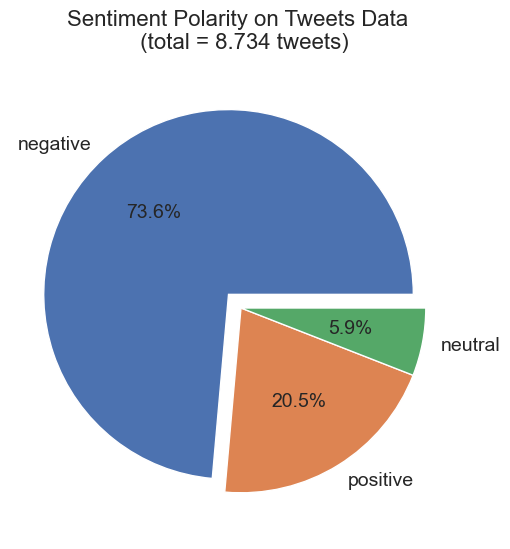

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in data['polarity'].value_counts()]
labels = list(data['polarity'].value_counts().index)
explode = [0.1 if i == 0 else 0 for i in range(len(sizes))]  # set explode values based on index

ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data \n (total = 8.734 tweets)', fontsize=16, pad=20)

plt.savefig('hasil2stem/polarity.png')
plt.show()
plt.close()

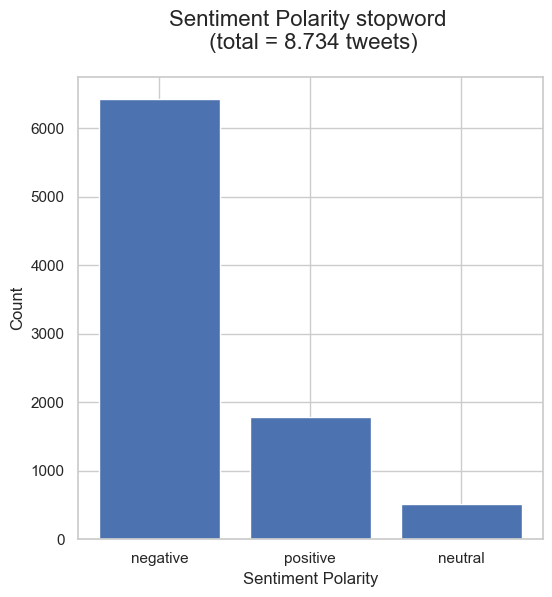

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in data['polarity'].value_counts()]
labels = list(data['polarity'].value_counts().index)

ax.bar(labels, sizes)
ax.set_xlabel('Sentiment Polarity')
ax.set_ylabel('Count')
ax.set_title('Sentiment Polarity stopword \n (total = 8.734 tweets)', fontsize=16, pad=20)

plt.savefig('hasil2stem/polarity1.png')
plt.show()
plt.close()

In [20]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = data[data['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_normalisasi', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets

,text_normalisasi,polarity_score,polarity
1,ibu kota negara belum jadi bos cuman uu nya sudah ada dan disyahkan bagaimana touch si bos ini kayaknya terlalu update infonya makanya kebablasan tertawa tertawa tertawa tertawa tertawa tertawa,32,positive
2,tertawa tertawa tertawa biar ibu kota negara nanti berarti ini kota nantinya dan kota nya bisa di kata-katain tertawa tertawa tertawa kelucuan yang fantastis,30,positive
3,csr tidak sebesar itu juga keles ada batasan nya bisnis ibu kota negara itu tidak viable di lihat dari sisi manapun kamu pinter tapi ke keblinger kesombongan tidak mudah saja tidak bisa kamu lihat dari perspektif yang jernih cinta sama sosok boleh bego jangan,24,positive
4,hasil survei ipo menyatakan persen responden puas kinerja jokowi dan persen tidak puas nah pak jokowi yang ini ajak saweran obligasi jutaan pak siapa tahu bisa menambah dana ibu kota negara termasuk deny siregar dan kawan nya pak jangan lupa panglima biawak,21,positive
5,islam tidak menentang budaya selama budaya itu tidak menyelisihi syariat faham yang namanya judul nya ritual di mana mana itu ada unsur magisnya ada campur tangan pihak ke tujuannya memintah berkah perlindungan dan pertolongan biar sukses bikin ibu kota negara tidak mengikuti syariat,20,positive
...,...,...,...
1784,lagi bingung mengambil langkah penyelamatan anaknya kroninya ibu kota negara dan proyek bermasalah lainnya pemilu tinggal th bulan waktu bergerak sangat cepat,1,positive
1785,baru tahu ada ritual ini ibu kota negara indonesia klenik nusantara anies ikutan juga iya wkwkwkwkw kasihan saja,1,positive
1786,melainkan impian pribadi seseorang selayaknya membangun prasasti hanya proyek ibu kota negara lebih kepada misi keajaiban mukjizat membangun kota semalam seperti bandung bondowoso candi tidak belajar dari bandung bondowoso setelah seribu kuil kurang satu lalu digenapi dengan kutukan,1,positive
1787,nambah tahun pemerintahannya berkemah di ibu kota negara bersama para mebterinya di ibu kota jakarta presiden baru,1,positive


In [21]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = data[data['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_normalisasi', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_normalisasi,polarity_score,polarity
1,urus minyak goreng bahan bakar minyak saja tidak becus negara indonesia sudah miskin diakibatkan hutang korupsi mafia tanah mafia pajak buzzer harun misi ku dan yang lainnya pindah ibu kota bukan keadaan darurat apalagi membangun ibu kota negara adalah pihak swasta negara harus bayar sewa kepada swasta,-45,negative
2,pusing nambah utang susah tunda pemilu ditolak anak dilaporkan kuliah kerja nyata ibu kota negara tidak ada duit mau bohong lagi rakyat sudah hapal karena terlalu sering dikibulin pusing tidak memikirkan minyak goreng langka gas mahal iya bodo amat rakyat kian susah,-45,negative
3,egois itu kalau - maksa ibu kota negara - maksa pemilu ditunda - maksa kereta cepat jakarta bandung - maksa rakyat bayar pajak - maksa vaksin - maksa daftar bpjs dan lain-lain silahkan menambahkan sendiri saking banyaknya yang mau ditulis,-42,negative
4,usualan itu bebas usul kpkpercepat menangani laporan korupsi usul batalkan ibu kota negara usul usut proyek kereta cepat bandung-jakarta usul suruh mereka bayar utang negara usul sebelum negara bangkrut periksa semua proyek heheheheee kan usulan saja realisasinya nanti,-41,negative
5,tertawa lawak emg di negeri penyamun kalau korupsi sekarang berita nya tidak seberapa menjual lebih baik bahas radikal kerusakan lagi booming dan menjual berita nya berita ibu kota negara ketutup radikal kerusakan berita minyak goreng ketutup berita wayang,-38,negative
6,kalau saya tetap tolak ibu kota negara buat apa buat siapa ibu kota negara rakyat sedang susah hutang menumpuk bayar hutang saja kesulitan bahkan mau berhutang lagi buat hal tidak darurat tolak ibu kota negara,-37,negative
7,- janji esemka mendunia akhirnya lenyap entah kemana berkunjung ke petani padi akhirnya impor beras berkunjung ke petani garam akhirnya impor garam berkunjung ke perkebunan sawit minyak goreng jadi langka saya kuatir berkunjung ke titik nol ibu kota negara nanti investor pada kabur,-36,negative
8,mampus kalian baru tahu kena tipu kalau dibilang jin tempat buang anak kalian demo tapi lebih tidak dihargai lagi kalau kepala ibu kota negara atau wakil ibu kota negara bukan asli orang kalimantan berarti kalian tidak dihargai mampus mampus mampus,-35,negative
9,apa sih yang tidak maksa rencana pindah ibu kota negara asn wajib pindah ksn vaksin maksa pacar maksa bpjs maksa eh maksa minta periode bertaubatlah,-35,negative
10,presiden bangun jalan til smp jalan tol rencana bikin ibu kota negara rakyat disuruh bantu dari mulai sembilan bahan pokok listrik gas bahan bakar minyak naik semua bpjs dipaksa masih pula disuruh makan singkong jaman makin maju tapi otak tambah dongok pejabat ini serakah tanpa batas,-34,negative


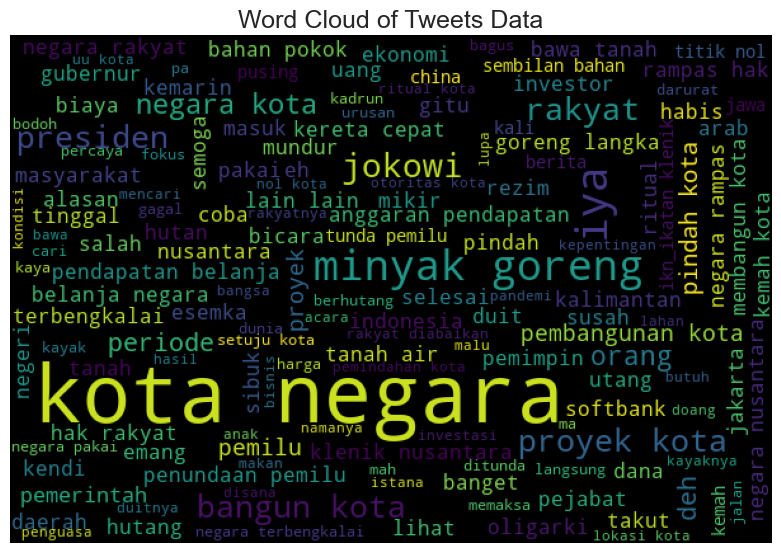

In [22]:
# Visualize word cloud
from wordcloud import WordCloud
list_words=''
for tweet in data['tweet_tokens_WSW']:
    for word in tweet:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.savefig('hasil2stem/wordcloud.png')
plt.show()

In [23]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]
        
        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)
            
    return positive_words, negative_words

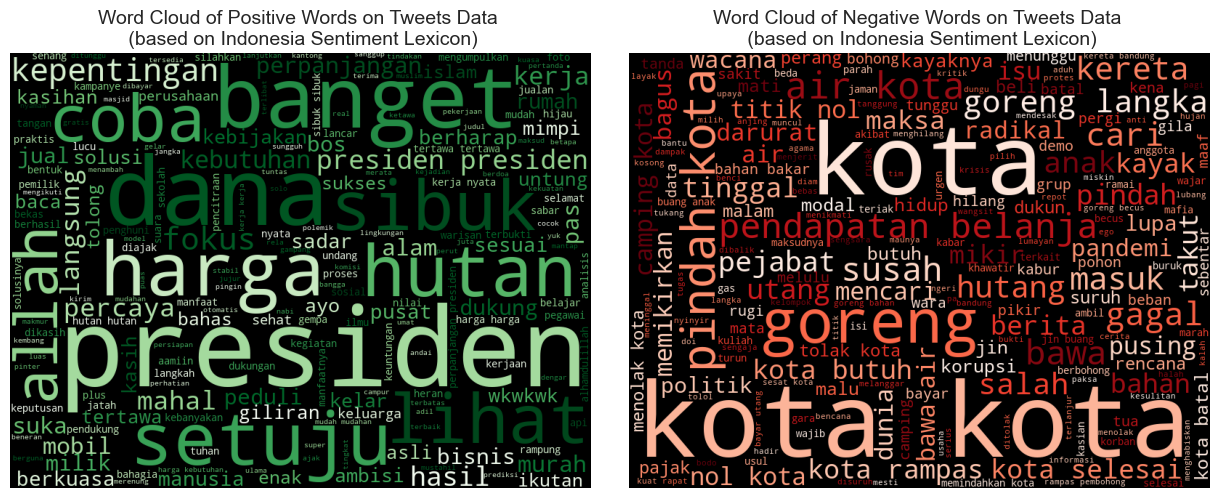

In [24]:
# Visualize positive and negative word cloud

sentiment_words = data['tweet_tokens_WSW'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')
plt.savefig('hasil2stem/wordcloud_positif_negatif.png')
plt.show()